In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, training will default to CPU.")

No GPU found, training will default to CPU.


In [5]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import os
#Check number of images in each folder
path = "/content/drive/MyDrive/KaggleData/Image_Dataset/"
dir_list = [os.path.join(path,i) for i in os.listdir(path) if os.path.isdir(os.path.join(path,i))]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict

{'Benign': 2480, 'Malignant': 5429}

In [ ]:
#Checking the len
len(os.listdir("/content/drive/MyDrive/KaggleData/Image_Dataset/"))

2

In [11]:
#Function to read the dataset from a specified directory
def import_images(folder,target):
    images = []
    for item in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,item), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append([img,target])
    return images

In [12]:
#Importing the dataset from the specified directory using the created function and assign them with labels
#Where 0 is for Benign, and 1 is for Malignant
benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Benign",0)
malignant = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Malignant",1)

In [13]:
full_data = benign + malignant  # Create a new list containing elements of both

In [ ]:
!pip install opencv-python-headless


In [8]:
import pickle

# Save the full dataset using Pickle
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/full_dataset.pkl', 'wb') as f:
    pickle.dump(full_data, f)
print("Dataset saved successfully!")


Dataset saved successfully!


In [28]:
import pickle

with open('/content/drive/MyDrive/KaggleData/Image_Dataset/full_dataset.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print("Dataset successfully loaded.")
print(f"Total number of samples in the dataset: {len(loaded_data)}")

Dataset successfully loaded.
Total number of samples in the dataset: 7909


In [ ]:
benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Benign", 0)  # Call your function

# # Check the type of the entire returned dataset
print(type(benign))

# # Check the type of the first element within the dataset
if benign:  # Check if the list is not empty
    print(type(benign[0]))

    benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Malignant", 1)  # Call your function

# # Check the type of the entire returned dataset
print(type(malignant))

# # Check the type of the first element within the dataset
if benign:  # Check if the list is not empty
    print(type(malignant[1]))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


Spliting Data/Stratification: to ensure each split maintains a label
distribution similar to the original dataset (particularly important for imbalanced datasets) to ensure that both validation and test sets are representative of the overall dataset, supporting more reliable evaluation and tuning of my model.

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have a list of tuples (image, label)
full_images = np.array([item[0] for item in full_data])  # Extract images
full_labels = np.array([item[1] for item in full_data])  # Extract labels for stratification

# Perform the dataset splitting into training and test set (with stratification)
train_images, test_images, train_labels, test_labels = train_test_split(
    full_images, full_labels, test_size=0.1, random_state=30, stratify=full_labels
)

# Extracting validation dataset from the training data (with stratification)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=(0.1/0.9), random_state=30, stratify=train_labels
)




In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2



# Function to apply Z-score normalization per image
def z_score_normalization(image):
    image_normalized = (image - np.mean(image, axis=(0, 1), keepdims=True)) / np.std(image, axis=(0, 1), keepdims=True)
    # Rescale the normalized image to the range [0, 1]
    min_val = image_normalized.min(axis=(0, 1), keepdims=True)
    max_val = image_normalized.max(axis=(0, 1), keepdims=True)
    image_rescaled = (image_normalized - min_val) / (max_val - min_val)
    return image_rescaled

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if image.ndim == 3 and image.shape[2] == 3:  # Color image
        # Convert to uint8 as CLAHE expects 8-bit input
        image_uint8 = (image * 255).astype(np.uint8)
        clahe_img = np.empty_like(image_uint8)
        for i in range(3):  # Apply CLAHE to each channel
            clahe_img[:, :, i] = clahe.apply(image_uint8[:, :, i])
        # Convert back to float32 for consistency in processing and visualization
        clahe_img = clahe_img.astype(np.float32) / 255
        return clahe_img
    else:  # Grayscale image
        image_uint8 = (image * 255).astype(np.uint8)
        clahe_img = clahe.apply(image_uint8)
        return clahe_img.astype(np.float32) / 255

# Modified function to preprocess datasets and return both normalized and CLAHE images
def preprocess_datasets(images):
    normalized_images = np.zeros_like(images, dtype=np.float32)
    clahe_images = np.zeros_like(images, dtype=np.float32)
    for i, img in enumerate(images):
        normalized_img = z_score_normalization(img)
        normalized_images[i] = normalized_img
        clahe_img = apply_clahe(normalized_img)
        clahe_images[i] = clahe_img
    return normalized_images, clahe_images

# Apply preprocessing to the training dataset
train_images_normalized, train_images_clahe = preprocess_datasets(train_images)

# Apply preprocessing to the validation dataset
val_images_normalized, val_images_clahe = preprocess_datasets(val_images)

# Apply preprocessing to the test dataset
test_images_normalized, test_images_clahe = preprocess_datasets(test_images)


# Apply preprocessing to the training dataset
train_images_normalized, train_images_clahe = preprocess_datasets(train_images)
print("Preprocessing (Z-score normalization and CLAHE) completed for training images.")

# Apply preprocessing to the validation dataset
val_images_normalized, val_images_clahe = preprocess_datasets(val_images)
print("Preprocessing (Z-score normalization and CLAHE) completed for validation images.")

# Apply preprocessing to the test dataset
test_images_normalized, test_images_clahe = preprocess_datasets(test_images)
print("Preprocessing (Z-score normalization and CLAHE) completed for test images.")



Preprocessing (Z-score normalization and CLAHE) completed for training images.
Preprocessing (Z-score normalization and CLAHE) completed for validation images.
Preprocessing (Z-score normalization and CLAHE) completed for test images.


In [32]:
import numpy as np
import cv2

# Function to apply CLAHE to a single channel
def apply_clahe_channel(channel, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(channel)

# Function to preprocess images with CLAHE
def preprocess_datasets(images):
    clahe_images = np.zeros_like(images, dtype=np.float32)
    for i, img in enumerate(images):
        # If the images are not already in uint8 format, convert them
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Check if the images are in color (3 channels)
        if img.ndim == 3 and img.shape[2] == 3:
            # Convert to LAB color space
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            # Apply CLAHE to the L channel and merge back
            lab_planes = list(cv2.split(lab))
            lab_planes[0] = apply_clahe_channel(lab_planes[0])
            lab = cv2.merge(lab_planes)
            # Convert back to RGB color space
            img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        else:
            # Apply CLAHE to a single channel (grayscale)
            img_clahe = apply_clahe_channel(img)

        # Store the processed image
        clahe_images[i] = img_clahe.astype(np.float32) / 255  # Ensure that the image is float32 and normalized

    return clahe_images

# Assuming `train_images`, `val_images`, and `test_images` are numpy arrays with the correct shape and dtype
# Apply preprocessing to the training dataset
train_images_clahe = preprocess_datasets(train_images)
print("CLAHE preprocessing completed for training images.")

# Apply preprocessing to the validation dataset
val_images_clahe = preprocess_datasets(val_images)
print("CLAHE preprocessing completed for validation images.")

# Apply preprocessing to the test dataset
test_images_clahe = preprocess_datasets(test_images)
print("CLAHE preprocessing completed for test images.")


CLAHE preprocessing completed for training images.
CLAHE preprocessing completed for validation images.
CLAHE preprocessing completed for test images.


In [34]:
# Save the processed data
import pickle

# After data are processed data in sets like:
# train_images_processed, val_images_processed, test_images_processed
# And corresponding labels:  train_labels, val_labels, test_labels

with open('/content/drive/MyDrive/KaggleData/Image_Dataset/CLAHE_.pkl', 'wb') as f:
    pickle.dump({
        'train_images': train_images_clahe,
        'train_labels': train_labels,
        'val_images': val_images_clahe,
        'val_labels': val_labels,
        'test_images': test_images_clahe,
        'test_labels': test_labels
    }, f)

print("Dataset saved successfully!")

Dataset saved successfully!


In [35]:
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/CLAHE_.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print("Dataset successfully loaded.")
print(f"Total number of samples in the dataset: {len(loaded_data)}")

Dataset successfully loaded.
Total number of samples in the dataset: 6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [36]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

IMG_SIZE = 224  # Assuming this is the correct image size

# Load the processed dataset
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/CLAHE_.pkl', 'rb') as file:
    data = pickle.load(file)

# Extract datasets and labe
train_images_clahe = data['train_images']
train_labels = data['train_labels']
val_images_clahe = data['val_images']
val_labels = data['val_labels']
test_images_clahe = data['test_images']
test_labels = data['test_labels']

# Data is already split into training, validation, and test sets,
# there is no need to perform a train/test split again.
# Directly apply RandomOverSampler on the training data
ros = RandomOverSampler(random_state=42)

# Reshaping is only necessary if your images are not already flattened for the RandomOverSampler
# Assuming your images are (224, 224, 3), you would reshape for RandomOverSampler like so:
training_data_reshaped = train_images_normalized.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

# Apply RandomOverSampler
training_data_resampled, training_labels_resampled = ros.fit_resample(training_data_reshaped, train_labels)

# Reshape the data back to its original shape after oversampling
training_dataset = training_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Note: Validation and test datasets do not need oversampling.
# You can directly use val_images_processed and test_images_processed as they are.

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(val_images_clahe)}")
print(f"Test dataset size: {len(test_images_clahe)}")


Training dataset size: 8686
Validation dataset size: 791
Test dataset size: 791


# Model Training

In [37]:
#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [38]:
#Setting the batch size for the cnn model
bs = 64

In [39]:
#Defining Image Data Generator for image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  # Example color space augmentation
    channel_shift_range=20  # Example for randomly shifting color channels
)

# Custom CNN Model 1

In [40]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (224,224,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Fifth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 55, 55, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 27, 27, 128)      

In [41]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [42]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

In [44]:
# Assume the datagen, rlrp, and bs have been defined earlier in your code
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# # No need to reshape images here as we're using them directly with ImageDataGenerator
# Extract training, validation, and test datasets
train_images_clahe = data['train_images']
train_labels = data['train_labels']
val_images_clahe = data['val_images']
val_labels = data['val_labels']
test_images_clahe = data['test_images']
test_labels = data['test_labels']




        # Assuming cancer_model is your model that's ready to be trained
history = cancer_model.fit(datagen.flow(train_images, train_labels, batch_size=bs),
                           validation_data=(val_images, val_labels),
                           epochs=50,
                           callbacks=[rlrp],
                           verbose=1)


Epoch 1/50
99/99 [==============================] - 76s 767ms/step - loss: 15.7952 - accuracy: 0.7104 - val_loss: 0.4840 - val_accuracy: 0.8205 - lr: 9.0992e-04
Epoch 2/50
99/99 [==============================] - 77s 774ms/step - loss: 0.4422 - accuracy: 0.8279 - val_loss: 0.4873 - val_accuracy: 0.8369 - lr: 8.3472e-04
Epoch 3/50
99/99 [==============================] - 75s 758ms/step - loss: 0.4476 - accuracy: 0.8254 - val_loss: 0.4820 - val_accuracy: 0.8394 - lr: 7.7101e-04
Epoch 4/50
99/99 [==============================] - 76s 767ms/step - loss: 0.4152 - accuracy: 0.8401 - val_loss: 0.4772 - val_accuracy: 0.8180 - lr: 7.1633e-04
Epoch 5/50
99/99 [==============================] - 75s 758ms/step - loss: 0.4116 - accuracy: 0.8389 - val_loss: 0.4155 - val_accuracy: 0.8344 - lr: 6.6890e-04
Epoch 6/50
99/99 [==============================] - 76s 765ms/step - loss: 0.3986 - accuracy: 0.8492 - val_loss: 0.4087 - val_accuracy: 0.8470 - lr: 6.2735e-04
Epoch 7/50
99/99 [=====================

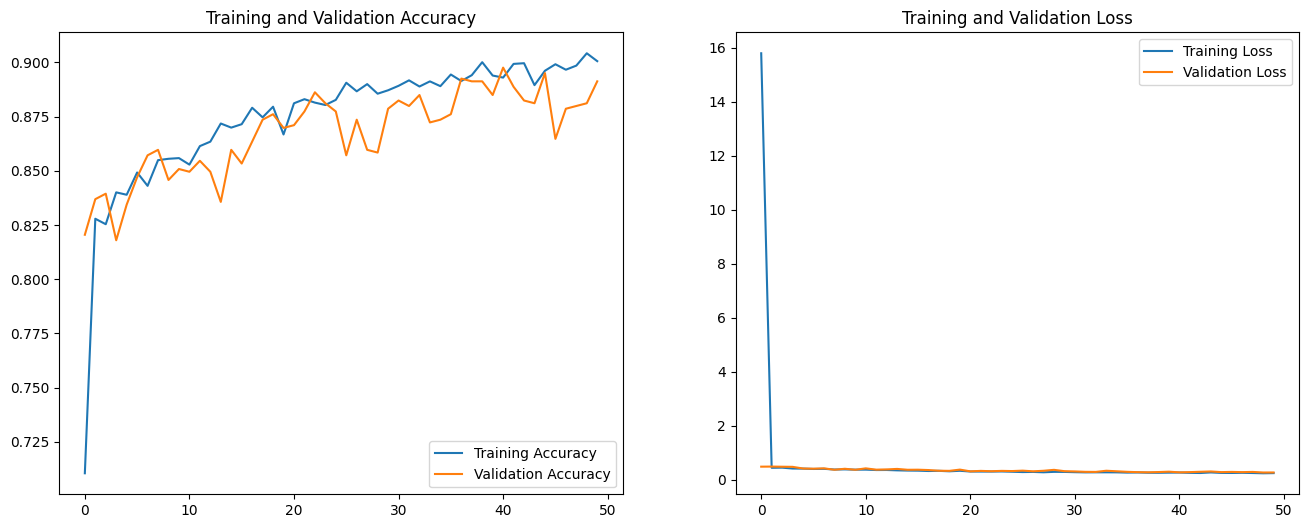

In [45]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy increases over time but with fluctuations, suggesting that the model is learning but also facing some variance issues with the validation set.
The training loss decreases as expected, but the validation loss is much more stable after an initial descent. The fact that it doesn't increase significantly is a positive sign, indicating there is no substantial overfitting.
There is a gap between the training and validation accuracy, suggesting some overfitting, although this gap is relatively sma

# Performance Evaluation of custom CNN model 1

Given my setup, as I want to evaluate the performance of my custom CNN model accurately, I should primarily use the validation set during the model development phase for tuning and early stopping, and finally, the test set for evaluating how well the model generalizes to new, unseen data. This approach ensures that my model's performance metrics reflect its ability to work with data it hasn't been trained on, which is a critical measure of its effectiveness in real-world applications.

In [46]:
import pickle

# Load the processed dataset
# Load the processed dataset
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/CLAHE_.pkl', 'rb') as file:
    data = pickle.load(file)

# Extract datasets
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']  # Ensure this line is executed
test_labels = data['test_labels']


# Predictions on validation set
y_val_pred = cancer_model.predict(val_images)

# Evaluate performance on the validation set
# (You can use metrics like accuracy, confusion matrix, etc., as shown in the previous response.)

# After finalizing the model, predict on the test set
y_test_pred = cancer_model.predict(test_images)

# Evaluate performance on the test set
# This gives you an unbiased evaluation of your model's generalization capability


25/25 [==============================] - 0s 18ms/step


In [48]:
print(y_test_pred)

[[0.7936297 ]
 [0.7876191 ]
 [0.8278743 ]
 [0.8424626 ]
 [0.81991005]
 [0.8198705 ]
 [0.785175  ]
 [0.8122318 ]
 [0.81126285]
 [0.8407636 ]
 [0.79285926]
 [0.8399487 ]
 [0.80414385]
 [0.79703987]
 [0.83336854]
 [0.82038516]
 [0.7457916 ]
 [0.8417605 ]
 [0.8349409 ]
 [0.8016627 ]
 [0.82202715]
 [0.80610114]
 [0.77544254]
 [0.8157284 ]
 [0.8102322 ]
 [0.8172254 ]
 [0.782974  ]
 [0.7895213 ]
 [0.827176  ]
 [0.8095832 ]
 [0.8469058 ]
 [0.8174533 ]
 [0.8429149 ]
 [0.8185635 ]
 [0.7058256 ]
 [0.82736826]
 [0.8221277 ]
 [0.82601666]
 [0.804258  ]
 [0.8325725 ]
 [0.80662346]
 [0.8282658 ]
 [0.81809855]
 [0.8192265 ]
 [0.8104648 ]
 [0.8371698 ]
 [0.8406492 ]
 [0.82854754]
 [0.8363004 ]
 [0.77910566]
 [0.8275118 ]
 [0.7893335 ]
 [0.8357651 ]
 [0.81152034]
 [0.83439   ]
 [0.7758818 ]
 [0.78676087]
 [0.8094423 ]
 [0.82768023]
 [0.8264024 ]
 [0.82444155]
 [0.8061132 ]
 [0.84484994]
 [0.7782276 ]
 [0.8333591 ]
 [0.8053261 ]
 [0.80985415]
 [0.8063527 ]
 [0.83442813]
 [0.81036514]
 [0.81835234]
 [0.73

In [49]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_test_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

<ipython-input-49-d15972a3d86d>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_test_pred]


In [ ]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_test_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0
 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 

<ipython-input-36-d15972a3d86d>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_test_pred]


In [51]:
#Classification report
print(classification_report(test_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.69      1.00      0.81       543

    accuracy                           0.69       791
   macro avg       0.34      0.50      0.41       791
weighted avg       0.47      0.69      0.56       791



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0 248]
 [  0 543]]


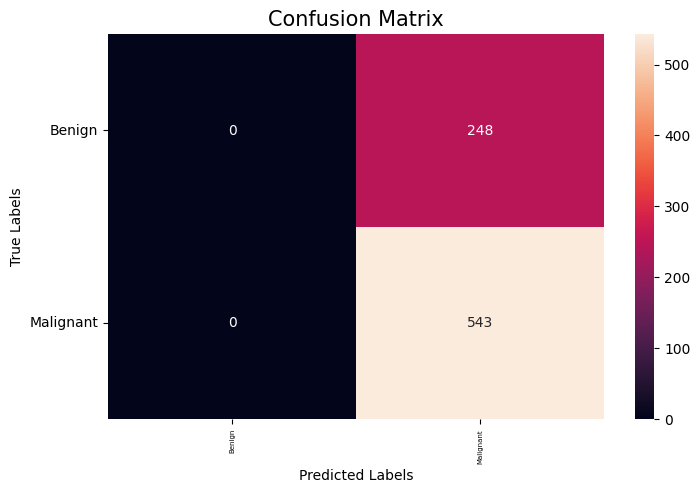

In [52]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

In [54]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_predictions)
print('Accuracy: %f' % accuracy)

Accuracy: 0.686473


In [55]:
#Precision
precision = precision_score(test_labels, rounded_predictions)
print('Precision: %f' % precision)

Precision: 0.686473


In [56]:
# Recall
recall = recall_score(test_labels, rounded_predictions, pos_label=1)
print('Recall: %f' % recall)

Recall: 1.000000


In [57]:
#Specificity
specificity = recall_score(test_labels, rounded_predictions, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.000000


In [58]:
#F1-score
F1_score = f1_score(test_labels, rounded_predictions)
print('F1_score: %f' % F1_score)

F1_score: 0.814093


# ROC CURVE

In [59]:
print("test_labels shape:", test_labels.shape)
print("y_pred shape:", y_test_pred.shape)

test_labels shape: (791,)
y_pred shape: (791, 1)


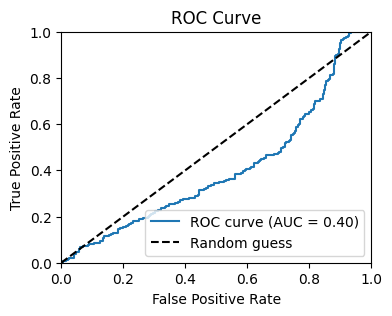

In [60]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_test_pred)
fpr, tpr, thresholds = roc_curve(test_labels, y_test_pred[:, 0])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()